In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import os

import utils
from environment import RULEnvironment

from stable_baselines3 import DQN 
from stable_baselines3.common.env_checker import check_env

from stable_baselines3.common.monitor import Monitor

### Load and preprocess train data

In [2]:
# Config
figsize = (9, 3)

In [3]:
data_path = "./data"
data = utils.load_data(data_path)
data.head()

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD001,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,train_FD001,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,train_FD001,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,train_FD001,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,train_FD001,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [4]:
# Last column is the RUL (Label)
dt_in = list(data.columns[3:-1])
data[dt_in].describe()

,p1,p2,p3,s1,s2,s3,s4,s5,s6,s7,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,...,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000
mean,17.211973,0.410004,95.724344,485.840890,597.361022,1467.035653,1260.956434,9.894999,14.424935,359.729968,...,338.789821,2349.645243,8088.950972,9.054747,0.025185,360.698801,2273.754039,98.389146,25.942709,15.565700
std,16.527988,0.367938,12.359044,30.420388,42.478516,118.175261,136.300073,4.265554,6.443922,174.133835,...,164.193480,111.167242,80.623257,0.751581,0.004997,31.021430,142.513114,4.656270,11.691422,7.015067
min,-0.008700,-0.000600,60.000000,445.000000,535.480000,1242.670000,1023.770000,3.910000,5.670000,136.170000,...,128.310000,2027.570000,7845.780000,8.156300,0.020000,302.000000,1915.000000,84.930000,10.160000,6.010500
25%,0.001300,0.000200,100.000000,449.440000,549.960000,1357.360000,1126.830000,5.480000,8.000000,175.710000,...,164.790000,2387.970000,8070.530000,8.439250,0.020000,332.000000,2212.000000,100.000000,14.330000,8.601300
50%,19.998100,0.620000,100.000000,489.050000,605.930000,1492.810000,1271.740000,9.350000,13.660000,341.690000,...,321.690000,2388.070000,8118.590000,9.030100,0.030000,367.000000,2319.000000,100.000000,24.920000,14.953500
75%,35.001500,0.840000,100.000000,518.670000,642.340000,1586.590000,1402.200000,14.620000,21.610000,553.290000,...,521.340000,2388.160000,8139.410000,9.344200,0.030000,392.000000,2388.000000,100.000000,38.820000,23.294600
max,42.008000,0.842000,100.000000,518.670000,645.110000,1616.910000,1441.490000,14.620000,21.610000,570.810000,...,537.490000,2390.490000,8293.720000,11.066900,0.030000,400.000000,2388.000000,100.000000,39.890000,23.950500


In [5]:
# Check for null-values
data[dt_in].isnull().any().any()

# No null values

False

In [6]:
# Standardize all the daa-columns
data_sv = data.copy()
data_sv[dt_in] = (data_sv[dt_in] - data_sv[dt_in].mean()) / data_sv[dt_in].std()
data_sv.head()

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD001,1,1,-1.041426,-1.115415,0.345954,1.079181,1.046623,1.037987,1.024530,...,0.345198,0.616063,-0.845214,0.963586,1.009019,0.801652,0.345954,1.121959,1.119490,191
1,train_FD001,1,2,-1.041268,-1.115143,0.345954,1.079181,1.054391,1.055926,1.043166,...,0.345648,0.527627,-0.828849,0.963586,1.009019,0.801652,0.345954,1.116827,1.120146,190
2,train_FD001,1,3,-1.041644,-1.113512,0.345954,1.079181,1.059100,1.023517,1.050943,...,0.345288,0.549209,-0.847476,0.963586,0.944547,0.801652,0.345954,1.112550,1.108828,189
3,train_FD001,1,4,-1.041341,-1.114327,0.345954,1.079181,1.059100,0.979514,1.033848,...,0.345738,0.556651,-0.913470,0.963586,1.009019,0.801652,0.345954,1.106563,1.113061,188
4,train_FD001,1,5,-1.041498,-1.114871,0.345954,1.079181,1.059570,0.980022,1.065763,...,0.345378,0.556279,-0.832042,0.963586,1.041254,0.801652,0.345954,1.108273,1.117409,187


In [7]:
data_sv_dict = utils.split_by_field(data_sv, field='src')
print('{{{}}}'.format(', '.join(f'{k}: ...' for k in data_sv_dict.keys())))

{train_FD001: ..., train_FD002: ..., train_FD003: ..., train_FD004: ...}


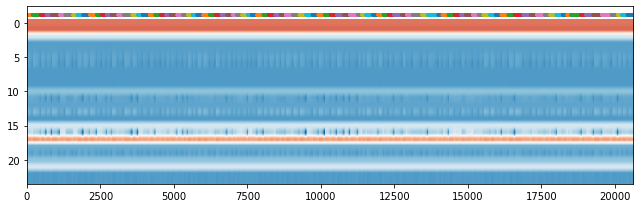

In [8]:
tmp = data_sv_dict['train_FD001']
utils.plot_dataframe(tmp[dt_in], labels=tmp['machine'], figsize=figsize)

### Train environment

In [9]:
env = RULEnvironment(data_sv, dt_in)

/Users/andreastettejessen/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [10]:
states = env.observation_space.shape
actions = env.action_space.n
states

(24,)

In [11]:
#check_env(env)

### Test environment

In [12]:
data_path = "./data"
data_test = utils.load_data(data_path, test=True)
dt_in_test = list(data_test.columns[3:-1])
data_test.describe()

# 707 machines
# Max amount of cycles: 486

,machine,cycle,p1,p2,p3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
count,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,...,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000
mean,372.662478,95.406589,17.243810,0.410887,95.748591,485.791314,597.153354,1464.738375,1257.240382,9.887805,...,2349.811235,8084.687648,9.046593,0.025039,360.088096,2273.841797,98.398282,25.949868,15.570426,94.406589
std,201.744654,74.311486,16.530141,0.368078,12.328151,30.426804,42.430629,117.856835,135.728855,4.265536,...,110.890533,78.956087,0.748390,0.005000,30.932463,142.218102,4.644631,11.701010,7.020590,74.311486
min,1.000000,1.000000,-0.008700,-0.000600,60.000000,445.000000,535.410000,1240.940000,1024.900000,3.910000,...,2027.740000,7849.800000,8.198000,0.020000,302.000000,1915.000000,84.930000,10.180000,6.123100,0.000000
25%,197.000000,38.000000,0.001300,0.000200,100.000000,449.440000,549.780000,1355.140000,1124.030000,5.480000,...,2387.950000,8068.360000,8.425600,0.020000,331.000000,2212.000000,100.000000,14.340000,8.607300,37.000000
50%,390.000000,80.000000,19.998200,0.620000,100.000000,489.050000,605.530000,1490.160000,1262.850000,9.350000,...,2388.050000,8113.100000,9.108500,0.030000,367.000000,2319.000000,100.000000,24.780000,14.872400,79.000000
75%,544.000000,135.000000,35.001500,0.840000,100.000000,518.670000,642.200000,1584.810000,1399.460000,14.620000,...,2388.110000,8136.630000,9.333900,0.030000,392.000000,2388.000000,100.000000,38.880000,23.331000,134.000000
max,707.000000,486.000000,42.008000,0.842000,100.000000,518.670000,644.320000,1609.690000,1434.120000,14.620000,...,2389.960000,8243.100000,11.030000,0.030000,398.000000,2388.000000,100.000000,39.750000,23.849600,485.000000


In [13]:
# Check for null-values
data_test[dt_in_test].isnull().any().any()

# No null values

False

In [14]:
# Standardize all the daa-columns
data_sv_test = data_test.copy()
data_sv_test[dt_in_test] = (data_sv_test[dt_in_test] - data_sv_test[dt_in_test].mean()) / data_sv_test[dt_in_test].std()
data_sv_test.describe()

,machine,cycle,p1,p2,p3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
count,104897.000000,104897.000000,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,...,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,1.048970e+05,104897.000000
mean,372.662478,95.406589,-3.528484e-14,2.732508e-13,6.284801e-14,2.248479e-13,1.892271e-13,2.131583e-13,2.235152e-13,-8.919049e-14,...,-1.056916e-12,-8.490742e-13,-4.943506e-14,1.125625e-12,5.621568e-15,-2.647621e-14,3.206756e-12,-3.476028e-14,-3.679688e-14,94.406589
std,201.744654,74.311486,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,74.311486
min,1.000000,1.000000,-1.043700e+00,-1.117934e+00,-2.899753e+00,-1.340638e+00,-1.455160e+00,-1.898900e+00,-1.711798e+00,-1.401419e+00,...,-2.904407e+00,-2.974915e+00,-1.133891e+00,-1.007737e+00,-1.877901e+00,-2.523179e+00,-2.899753e+00,-1.347736e+00,-1.345660e+00,0.000000
25%,197.000000,38.000000,-1.043095e+00,-1.115760e+00,3.448537e-01,-1.194714e+00,-1.116490e+00,-9.299280e-01,-9.814448e-01,-1.033353e+00,...,3.439317e-01,-2.067940e-01,-8.297717e-01,-1.007737e+00,-9.403744e-01,-4.348377e-01,3.448537e-01,-9.922108e-01,-9.918149e-01,37.000000
50%,390.000000,80.000000,1.666284e-01,5.681230e-01,3.448537e-01,1.070992e-01,1.974198e-01,2.156992e-01,4.132959e-02,-1.260814e-01,...,3.448334e-01,3.598500e-01,8.272022e-02,9.923125e-01,2.234515e-01,3.175278e-01,3.448537e-01,-9.998010e-02,-9.942553e-02,79.000000
75%,544.000000,135.000000,1.074261e+00,1.165823e+00,3.448537e-01,1.080583e+00,1.061654e+00,1.018792e+00,1.047822e+00,1.109402e+00,...,3.453745e-01,6.578638e-01,3.839000e-01,9.923125e-01,1.031664e+00,8.026981e-01,3.448537e-01,1.105044e+00,1.105402e+00,134.000000
max,707.000000,486.000000,1.498123e+00,1.171256e+00,3.448537e-01,1.080583e+00,1.111618e+00,1.229896e+00,1.303184e+00,1.109402e+00,...,3.620576e-01,2.006335e+00,2.650231e+00,9.923125e-01,1.225635e+00,8.026981e-01,3.448537e-01,1.179397e+00,1.179270e+00,485.000000


In [15]:
env_test = RULEnvironment(data_sv_test, dt_in_test)

/Users/andreastettejessen/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [16]:
nb_episodes = data_sv_test['machine'].max()

### Evaluation of model before and after training

In [17]:
def evaluate(model, environment, num_episodes=100):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    env = environment
    all_episode_rewards = []
    all_nr_of_actions = []
    for i in range(num_episodes):
        episode_rewards = []
        nr_of_actions = 0
        done = False
        obs = env.reset()
        while not done:
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)
            nr_of_actions += 1
        
        all_episode_rewards.append(sum(episode_rewards))
        all_nr_of_actions.append(nr_of_actions)
    plt.plot(all_episode_rewards)
    plt.plot(all_nr_of_actions)

    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return mean_episode_reward

In [18]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

In [19]:
env = Monitor(env, log_dir)

In [20]:
model = DQN("MlpPolicy", env, verbose = 1, tensorboard_log="./tensorboard/")

Using cpu device
Wrapping the env in a DummyVecEnv.


In [21]:
model.learn(total_timesteps=100000)


Logging to ./tensorboard/DQN_4
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 3.75     |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 274      |
|    time_elapsed     | 0        |
|    total_timesteps  | 15       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.5      |
|    ep_rew_mean      | 2.5      |
|    exploration_rate | 0.998    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 239      |
|    time_elapsed     | 0        |
|    total_timesteps  | 20       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.92     |
|    ep_rew_mean      | 2.92     |
|    exploration_rate | 0.997    |
| time/               | 

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.982    |
| time/               |          |
|    episodes         | 92       |
|    fps              | 255      |
|    time_elapsed     | 0        |
|    total_timesteps  | 194      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.981    |
| time/               |          |
|    episodes         | 96       |
|    fps              | 257      |
|    time_elapsed     | 0        |
|    total_timesteps  | 202      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.98     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.74     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.967    |
| time/               |          |
|    episodes         | 180      |
|    fps              | 272      |
|    time_elapsed     | 1        |
|    total_timesteps  | 345      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.75     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.966    |
| time/               |          |
|    episodes         | 184      |
|    fps              | 273      |
|    time_elapsed     | 1        |
|    total_timesteps  | 354      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.72     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.966    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.949    |
| time/               |          |
|    episodes         | 268      |
|    fps              | 297      |
|    time_elapsed     | 1        |
|    total_timesteps  | 536      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.948    |
| time/               |          |
|    episodes         | 272      |
|    fps              | 298      |
|    time_elapsed     | 1        |
|    total_timesteps  | 544      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.948    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.933    |
| time/               |          |
|    episodes         | 356      |
|    fps              | 302      |
|    time_elapsed     | 2        |
|    total_timesteps  | 701      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.932    |
| time/               |          |
|    episodes         | 360      |
|    fps              | 303      |
|    time_elapsed     | 2        |
|    total_timesteps  | 712      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.932    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.916    |
| time/               |          |
|    episodes         | 444      |
|    fps              | 311      |
|    time_elapsed     | 2        |
|    total_timesteps  | 883      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.915    |
| time/               |          |
|    episodes         | 448      |
|    fps              | 311      |
|    time_elapsed     | 2        |
|    total_timesteps  | 893      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.915    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.79     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.901    |
| time/               |          |
|    episodes         | 532      |
|    fps              | 313      |
|    time_elapsed     | 3        |
|    total_timesteps  | 1042     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.74     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.901    |
| time/               |          |
|    episodes         | 536      |
|    fps              | 312      |
|    time_elapsed     | 3        |
|    total_timesteps  | 1046     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.79     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.9      |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.885    |
| time/               |          |
|    episodes         | 620      |
|    fps              | 316      |
|    time_elapsed     | 3        |
|    total_timesteps  | 1212     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.884    |
| time/               |          |
|    episodes         | 624      |
|    fps              | 316      |
|    time_elapsed     | 3        |
|    total_timesteps  | 1219     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.883    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.867    |
| time/               |          |
|    episodes         | 708      |
|    fps              | 320      |
|    time_elapsed     | 4        |
|    total_timesteps  | 1398     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.867    |
| time/               |          |
|    episodes         | 712      |
|    fps              | 320      |
|    time_elapsed     | 4        |
|    total_timesteps  | 1405     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.866    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.852    |
| time/               |          |
|    episodes         | 796      |
|    fps              | 321      |
|    time_elapsed     | 4        |
|    total_timesteps  | 1562     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.851    |
| time/               |          |
|    episodes         | 800      |
|    fps              | 321      |
|    time_elapsed     | 4        |
|    total_timesteps  | 1573     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.85     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.834    |
| time/               |          |
|    episodes         | 884      |
|    fps              | 324      |
|    time_elapsed     | 5        |
|    total_timesteps  | 1743     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.833    |
| time/               |          |
|    episodes         | 888      |
|    fps              | 324      |
|    time_elapsed     | 5        |
|    total_timesteps  | 1753     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.833    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.2      |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.816    |
| time/               |          |
|    episodes         | 972      |
|    fps              | 327      |
|    time_elapsed     | 5        |
|    total_timesteps  | 1937     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.22     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.815    |
| time/               |          |
|    episodes         | 976      |
|    fps              | 327      |
|    time_elapsed     | 5        |
|    total_timesteps  | 1945     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.27     |
|    ep_rew_mean      | 2.27     |
|    exploration_rate | 0.814    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.799    |
| time/               |          |
|    episodes         | 1060     |
|    fps              | 329      |
|    time_elapsed     | 6        |
|    total_timesteps  | 2118     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.798    |
| time/               |          |
|    episodes         | 1064     |
|    fps              | 329      |
|    time_elapsed     | 6        |
|    total_timesteps  | 2125     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.797    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.781    |
| time/               |          |
|    episodes         | 1148     |
|    fps              | 331      |
|    time_elapsed     | 6        |
|    total_timesteps  | 2302     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.78     |
| time/               |          |
|    episodes         | 1152     |
|    fps              | 332      |
|    time_elapsed     | 6        |
|    total_timesteps  | 2315     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.779    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.765    |
| time/               |          |
|    episodes         | 1236     |
|    fps              | 331      |
|    time_elapsed     | 7        |
|    total_timesteps  | 2474     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.764    |
| time/               |          |
|    episodes         | 1240     |
|    fps              | 332      |
|    time_elapsed     | 7        |
|    total_timesteps  | 2489     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.763    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.748    |
| time/               |          |
|    episodes         | 1324     |
|    fps              | 331      |
|    time_elapsed     | 7        |
|    total_timesteps  | 2655     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.747    |
| time/               |          |
|    episodes         | 1328     |
|    fps              | 331      |
|    time_elapsed     | 8        |
|    total_timesteps  | 2660     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.747    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.8      |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.733    |
| time/               |          |
|    episodes         | 1412     |
|    fps              | 331      |
|    time_elapsed     | 8        |
|    total_timesteps  | 2815     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.731    |
| time/               |          |
|    episodes         | 1416     |
|    fps              | 331      |
|    time_elapsed     | 8        |
|    total_timesteps  | 2827     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.731    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.714    |
| time/               |          |
|    episodes         | 1500     |
|    fps              | 333      |
|    time_elapsed     | 9        |
|    total_timesteps  | 3013     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.713    |
| time/               |          |
|    episodes         | 1504     |
|    fps              | 333      |
|    time_elapsed     | 9        |
|    total_timesteps  | 3019     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.713    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.66     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.7      |
| time/               |          |
|    episodes         | 1588     |
|    fps              | 330      |
|    time_elapsed     | 9        |
|    total_timesteps  | 3156     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.65     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.7      |
| time/               |          |
|    episodes         | 1592     |
|    fps              | 330      |
|    time_elapsed     | 9        |
|    total_timesteps  | 3162     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.61     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.699    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.683    |
| time/               |          |
|    episodes         | 1676     |
|    fps              | 331      |
|    time_elapsed     | 10       |
|    total_timesteps  | 3333     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.683    |
| time/               |          |
|    episodes         | 1680     |
|    fps              | 331      |
|    time_elapsed     | 10       |
|    total_timesteps  | 3341     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.682    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.668    |
| time/               |          |
|    episodes         | 1764     |
|    fps              | 330      |
|    time_elapsed     | 10       |
|    total_timesteps  | 3495     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.667    |
| time/               |          |
|    episodes         | 1768     |
|    fps              | 330      |
|    time_elapsed     | 10       |
|    total_timesteps  | 3501     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.667    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.652    |
| time/               |          |
|    episodes         | 1852     |
|    fps              | 330      |
|    time_elapsed     | 11       |
|    total_timesteps  | 3668     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.651    |
| time/               |          |
|    episodes         | 1856     |
|    fps              | 330      |
|    time_elapsed     | 11       |
|    total_timesteps  | 3673     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.65     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.636    |
| time/               |          |
|    episodes         | 1940     |
|    fps              | 330      |
|    time_elapsed     | 11       |
|    total_timesteps  | 3831     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.635    |
| time/               |          |
|    episodes         | 1944     |
|    fps              | 330      |
|    time_elapsed     | 11       |
|    total_timesteps  | 3839     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.635    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.618    |
| time/               |          |
|    episodes         | 2028     |
|    fps              | 331      |
|    time_elapsed     | 12       |
|    total_timesteps  | 4022     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.617    |
| time/               |          |
|    episodes         | 2032     |
|    fps              | 331      |
|    time_elapsed     | 12       |
|    total_timesteps  | 4033     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.616    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.3      |
|    ep_rew_mean      | 2.3      |
|    exploration_rate | 0.599    |
| time/               |          |
|    episodes         | 2116     |
|    fps              | 333      |
|    time_elapsed     | 12       |
|    total_timesteps  | 4224     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.32     |
|    ep_rew_mean      | 2.32     |
|    exploration_rate | 0.598    |
| time/               |          |
|    episodes         | 2120     |
|    fps              | 333      |
|    time_elapsed     | 12       |
|    total_timesteps  | 4230     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.23     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.598    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.581    |
| time/               |          |
|    episodes         | 2204     |
|    fps              | 334      |
|    time_elapsed     | 13       |
|    total_timesteps  | 4411     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.12     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.58     |
| time/               |          |
|    episodes         | 2208     |
|    fps              | 333      |
|    time_elapsed     | 13       |
|    total_timesteps  | 4416     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.58     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.565    |
| time/               |          |
|    episodes         | 2292     |
|    fps              | 334      |
|    time_elapsed     | 13       |
|    total_timesteps  | 4582     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.564    |
| time/               |          |
|    episodes         | 2296     |
|    fps              | 333      |
|    time_elapsed     | 13       |
|    total_timesteps  | 4586     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.564    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.547    |
| time/               |          |
|    episodes         | 2380     |
|    fps              | 334      |
|    time_elapsed     | 14       |
|    total_timesteps  | 4767     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.546    |
| time/               |          |
|    episodes         | 2384     |
|    fps              | 334      |
|    time_elapsed     | 14       |
|    total_timesteps  | 4774     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.546    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.531    |
| time/               |          |
|    episodes         | 2468     |
|    fps              | 334      |
|    time_elapsed     | 14       |
|    total_timesteps  | 4938     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.53     |
| time/               |          |
|    episodes         | 2472     |
|    fps              | 334      |
|    time_elapsed     | 14       |
|    total_timesteps  | 4949     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.529    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.514    |
| time/               |          |
|    episodes         | 2556     |
|    fps              | 334      |
|    time_elapsed     | 15       |
|    total_timesteps  | 5111     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.514    |
| time/               |          |
|    episodes         | 2560     |
|    fps              | 334      |
|    time_elapsed     | 15       |
|    total_timesteps  | 5120     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.513    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.497    |
| time/               |          |
|    episodes         | 2644     |
|    fps              | 335      |
|    time_elapsed     | 15       |
|    total_timesteps  | 5293     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.496    |
| time/               |          |
|    episodes         | 2648     |
|    fps              | 335      |
|    time_elapsed     | 15       |
|    total_timesteps  | 5304     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.495    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.481    |
| time/               |          |
|    episodes         | 2732     |
|    fps              | 335      |
|    time_elapsed     | 16       |
|    total_timesteps  | 5466     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.48     |
| time/               |          |
|    episodes         | 2736     |
|    fps              | 334      |
|    time_elapsed     | 16       |
|    total_timesteps  | 5471     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.48     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.465    |
| time/               |          |
|    episodes         | 2820     |
|    fps              | 334      |
|    time_elapsed     | 16       |
|    total_timesteps  | 5631     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.464    |
| time/               |          |
|    episodes         | 2824     |
|    fps              | 334      |
|    time_elapsed     | 16       |
|    total_timesteps  | 5637     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.464    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.447    |
| time/               |          |
|    episodes         | 2908     |
|    fps              | 335      |
|    time_elapsed     | 17       |
|    total_timesteps  | 5819     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.446    |
| time/               |          |
|    episodes         | 2912     |
|    fps              | 335      |
|    time_elapsed     | 17       |
|    total_timesteps  | 5827     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.446    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.431    |
| time/               |          |
|    episodes         | 2996     |
|    fps              | 335      |
|    time_elapsed     | 17       |
|    total_timesteps  | 5989     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.431    |
| time/               |          |
|    episodes         | 3000     |
|    fps              | 335      |
|    time_elapsed     | 17       |
|    total_timesteps  | 5994     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.43     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.79     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.416    |
| time/               |          |
|    episodes         | 3084     |
|    fps              | 334      |
|    time_elapsed     | 18       |
|    total_timesteps  | 6145     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.415    |
| time/               |          |
|    episodes         | 3088     |
|    fps              | 334      |
|    time_elapsed     | 18       |
|    total_timesteps  | 6157     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.414    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.399    |
| time/               |          |
|    episodes         | 3172     |
|    fps              | 334      |
|    time_elapsed     | 18       |
|    total_timesteps  | 6323     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.399    |
| time/               |          |
|    episodes         | 3176     |
|    fps              | 334      |
|    time_elapsed     | 18       |
|    total_timesteps  | 6329     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.398    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.383    |
| time/               |          |
|    episodes         | 3260     |
|    fps              | 334      |
|    time_elapsed     | 19       |
|    total_timesteps  | 6491     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.382    |
| time/               |          |
|    episodes         | 3264     |
|    fps              | 334      |
|    time_elapsed     | 19       |
|    total_timesteps  | 6504     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.381    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.366    |
| time/               |          |
|    episodes         | 3348     |
|    fps              | 335      |
|    time_elapsed     | 19       |
|    total_timesteps  | 6677     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.365    |
| time/               |          |
|    episodes         | 3352     |
|    fps              | 335      |
|    time_elapsed     | 19       |
|    total_timesteps  | 6685     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.364    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.348    |
| time/               |          |
|    episodes         | 3436     |
|    fps              | 335      |
|    time_elapsed     | 20       |
|    total_timesteps  | 6863     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.347    |
| time/               |          |
|    episodes         | 3440     |
|    fps              | 335      |
|    time_elapsed     | 20       |
|    total_timesteps  | 6870     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.347    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.331    |
| time/               |          |
|    episodes         | 3524     |
|    fps              | 335      |
|    time_elapsed     | 21       |
|    total_timesteps  | 7039     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.331    |
| time/               |          |
|    episodes         | 3528     |
|    fps              | 335      |
|    time_elapsed     | 21       |
|    total_timesteps  | 7045     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.33     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.314    |
| time/               |          |
|    episodes         | 3612     |
|    fps              | 334      |
|    time_elapsed     | 21       |
|    total_timesteps  | 7217     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.314    |
| time/               |          |
|    episodes         | 3616     |
|    fps              | 334      |
|    time_elapsed     | 21       |
|    total_timesteps  | 7224     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.313    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.299    |
| time/               |          |
|    episodes         | 3700     |
|    fps              | 334      |
|    time_elapsed     | 22       |
|    total_timesteps  | 7379     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.298    |
| time/               |          |
|    episodes         | 3704     |
|    fps              | 334      |
|    time_elapsed     | 22       |
|    total_timesteps  | 7388     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.297    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.281    |
| time/               |          |
|    episodes         | 3788     |
|    fps              | 334      |
|    time_elapsed     | 22       |
|    total_timesteps  | 7572     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.28     |
| time/               |          |
|    episodes         | 3792     |
|    fps              | 334      |
|    time_elapsed     | 22       |
|    total_timesteps  | 7578     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.279    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.265    |
| time/               |          |
|    episodes         | 3876     |
|    fps              | 334      |
|    time_elapsed     | 23       |
|    total_timesteps  | 7742     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.263    |
| time/               |          |
|    episodes         | 3880     |
|    fps              | 334      |
|    time_elapsed     | 23       |
|    total_timesteps  | 7757     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.262    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.247    |
| time/               |          |
|    episodes         | 3964     |
|    fps              | 334      |
|    time_elapsed     | 23       |
|    total_timesteps  | 7923     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.247    |
| time/               |          |
|    episodes         | 3968     |
|    fps              | 334      |
|    time_elapsed     | 23       |
|    total_timesteps  | 7930     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.246    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.232    |
| time/               |          |
|    episodes         | 4052     |
|    fps              | 334      |
|    time_elapsed     | 24       |
|    total_timesteps  | 8087     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.231    |
| time/               |          |
|    episodes         | 4056     |
|    fps              | 334      |
|    time_elapsed     | 24       |
|    total_timesteps  | 8094     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.23     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.215    |
| time/               |          |
|    episodes         | 4140     |
|    fps              | 334      |
|    time_elapsed     | 24       |
|    total_timesteps  | 8259     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.215    |
| time/               |          |
|    episodes         | 4144     |
|    fps              | 334      |
|    time_elapsed     | 24       |
|    total_timesteps  | 8268     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.214    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.197    |
| time/               |          |
|    episodes         | 4228     |
|    fps              | 334      |
|    time_elapsed     | 25       |
|    total_timesteps  | 8450     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.197    |
| time/               |          |
|    episodes         | 4232     |
|    fps              | 334      |
|    time_elapsed     | 25       |
|    total_timesteps  | 8457     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.196    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.18     |
| time/               |          |
|    episodes         | 4316     |
|    fps              | 335      |
|    time_elapsed     | 25       |
|    total_timesteps  | 8632     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.179    |
| time/               |          |
|    episodes         | 4320     |
|    fps              | 335      |
|    time_elapsed     | 25       |
|    total_timesteps  | 8638     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.178    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.164    |
| time/               |          |
|    episodes         | 4404     |
|    fps              | 335      |
|    time_elapsed     | 26       |
|    total_timesteps  | 8800     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.163    |
| time/               |          |
|    episodes         | 4408     |
|    fps              | 335      |
|    time_elapsed     | 26       |
|    total_timesteps  | 8807     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.163    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.148    |
| time/               |          |
|    episodes         | 4492     |
|    fps              | 334      |
|    time_elapsed     | 26       |
|    total_timesteps  | 8964     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.147    |
| time/               |          |
|    episodes         | 4496     |
|    fps              | 334      |
|    time_elapsed     | 26       |
|    total_timesteps  | 8975     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.146    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.132    |
| time/               |          |
|    episodes         | 4580     |
|    fps              | 334      |
|    time_elapsed     | 27       |
|    total_timesteps  | 9138     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.131    |
| time/               |          |
|    episodes         | 4584     |
|    fps              | 334      |
|    time_elapsed     | 27       |
|    total_timesteps  | 9144     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.131    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.116    |
| time/               |          |
|    episodes         | 4668     |
|    fps              | 334      |
|    time_elapsed     | 27       |
|    total_timesteps  | 9303     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.115    |
| time/               |          |
|    episodes         | 4672     |
|    fps              | 334      |
|    time_elapsed     | 27       |
|    total_timesteps  | 9319     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.114    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.0997   |
| time/               |          |
|    episodes         | 4756     |
|    fps              | 334      |
|    time_elapsed     | 28       |
|    total_timesteps  | 9477     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.0989   |
| time/               |          |
|    episodes         | 4760     |
|    fps              | 334      |
|    time_elapsed     | 28       |
|    total_timesteps  | 9485     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.0984   |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.082    |
| time/               |          |
|    episodes         | 4844     |
|    fps              | 334      |
|    time_elapsed     | 28       |
|    total_timesteps  | 9663     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.0815   |
| time/               |          |
|    episodes         | 4848     |
|    fps              | 334      |
|    time_elapsed     | 28       |
|    total_timesteps  | 9668     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.0806   |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.0666   |
| time/               |          |
|    episodes         | 4932     |
|    fps              | 334      |
|    time_elapsed     | 29       |
|    total_timesteps  | 9825     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.0661   |
| time/               |          |
|    episodes         | 4936     |
|    fps              | 334      |
|    time_elapsed     | 29       |
|    total_timesteps  | 9830     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.0651   |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5020     |
|    fps              | 335      |
|    time_elapsed     | 29       |
|    total_timesteps  | 10020    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5024     |
|    fps              | 334      |
|    time_elapsed     | 29       |
|    total_timesteps  | 10024    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.19     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5108     |
|    fps              | 334      |
|    time_elapsed     | 30       |
|    total_timesteps  | 10197    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5112     |
|    fps              | 334      |
|    time_elapsed     | 30       |
|    total_timesteps  | 10202    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5196     |
|    fps              | 334      |
|    time_elapsed     | 30       |
|    total_timesteps  | 10358    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5200     |
|    fps              | 334      |
|    time_elapsed     | 30       |
|    total_timesteps  | 10366    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.79     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5284     |
|    fps              | 334      |
|    time_elapsed     | 31       |
|    total_timesteps  | 10518    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5288     |
|    fps              | 334      |
|    time_elapsed     | 31       |
|    total_timesteps  | 10526    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5372     |
|    fps              | 334      |
|    time_elapsed     | 31       |
|    total_timesteps  | 10694    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5376     |
|    fps              | 334      |
|    time_elapsed     | 32       |
|    total_timesteps  | 10702    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5460     |
|    fps              | 334      |
|    time_elapsed     | 32       |
|    total_timesteps  | 10879    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.12     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5464     |
|    fps              | 334      |
|    time_elapsed     | 32       |
|    total_timesteps  | 10891    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.12     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.32     |
|    ep_rew_mean      | 2.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5548     |
|    fps              | 335      |
|    time_elapsed     | 33       |
|    total_timesteps  | 11088    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.31     |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5552     |
|    fps              | 335      |
|    time_elapsed     | 33       |
|    total_timesteps  | 11096    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.32     |
|    ep_rew_mean      | 2.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5636     |
|    fps              | 334      |
|    time_elapsed     | 33       |
|    total_timesteps  | 11252    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5640     |
|    fps              | 334      |
|    time_elapsed     | 33       |
|    total_timesteps  | 11261    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5724     |
|    fps              | 334      |
|    time_elapsed     | 34       |
|    total_timesteps  | 11420    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5728     |
|    fps              | 334      |
|    time_elapsed     | 34       |
|    total_timesteps  | 11425    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5812     |
|    fps              | 334      |
|    time_elapsed     | 34       |
|    total_timesteps  | 11595    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5816     |
|    fps              | 334      |
|    time_elapsed     | 34       |
|    total_timesteps  | 11602    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5900     |
|    fps              | 334      |
|    time_elapsed     | 35       |
|    total_timesteps  | 11789    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5904     |
|    fps              | 334      |
|    time_elapsed     | 35       |
|    total_timesteps  | 11797    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5988     |
|    fps              | 334      |
|    time_elapsed     | 35       |
|    total_timesteps  | 11976    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5992     |
|    fps              | 334      |
|    time_elapsed     | 35       |
|    total_timesteps  | 11983    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.12     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6076     |
|    fps              | 334      |
|    time_elapsed     | 36       |
|    total_timesteps  | 12152    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6080     |
|    fps              | 334      |
|    time_elapsed     | 36       |
|    total_timesteps  | 12156    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.71     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6164     |
|    fps              | 333      |
|    time_elapsed     | 36       |
|    total_timesteps  | 12304    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.76     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6168     |
|    fps              | 334      |
|    time_elapsed     | 36       |
|    total_timesteps  | 12315    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.76     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6252     |
|    fps              | 333      |
|    time_elapsed     | 37       |
|    total_timesteps  | 12472    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6256     |
|    fps              | 333      |
|    time_elapsed     | 37       |
|    total_timesteps  | 12481    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6340     |
|    fps              | 333      |
|    time_elapsed     | 37       |
|    total_timesteps  | 12639    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6344     |
|    fps              | 333      |
|    time_elapsed     | 37       |
|    total_timesteps  | 12648    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.65     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6428     |
|    fps              | 332      |
|    time_elapsed     | 38       |
|    total_timesteps  | 12786    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.66     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6432     |
|    fps              | 332      |
|    time_elapsed     | 38       |
|    total_timesteps  | 12792    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.66     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6516     |
|    fps              | 332      |
|    time_elapsed     | 38       |
|    total_timesteps  | 12976    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.18     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6520     |
|    fps              | 332      |
|    time_elapsed     | 39       |
|    total_timesteps  | 12986    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.23     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6604     |
|    fps              | 333      |
|    time_elapsed     | 39       |
|    total_timesteps  | 13168    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.24     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6608     |
|    fps              | 333      |
|    time_elapsed     | 39       |
|    total_timesteps  | 13176    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.19     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6692     |
|    fps              | 333      |
|    time_elapsed     | 40       |
|    total_timesteps  | 13357    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6696     |
|    fps              | 333      |
|    time_elapsed     | 40       |
|    total_timesteps  | 13362    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6780     |
|    fps              | 333      |
|    time_elapsed     | 40       |
|    total_timesteps  | 13532    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6784     |
|    fps              | 333      |
|    time_elapsed     | 40       |
|    total_timesteps  | 13539    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.12     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6868     |
|    fps              | 333      |
|    time_elapsed     | 41       |
|    total_timesteps  | 13724    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6872     |
|    fps              | 333      |
|    time_elapsed     | 41       |
|    total_timesteps  | 13731    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6956     |
|    fps              | 333      |
|    time_elapsed     | 41       |
|    total_timesteps  | 13909    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6960     |
|    fps              | 333      |
|    time_elapsed     | 41       |
|    total_timesteps  | 13917    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7044     |
|    fps              | 333      |
|    time_elapsed     | 42       |
|    total_timesteps  | 14090    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7048     |
|    fps              | 333      |
|    time_elapsed     | 42       |
|    total_timesteps  | 14096    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7132     |
|    fps              | 333      |
|    time_elapsed     | 42       |
|    total_timesteps  | 14270    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7136     |
|    fps              | 333      |
|    time_elapsed     | 42       |
|    total_timesteps  | 14279    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7220     |
|    fps              | 332      |
|    time_elapsed     | 43       |
|    total_timesteps  | 14432    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7224     |
|    fps              | 332      |
|    time_elapsed     | 43       |
|    total_timesteps  | 14439    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7308     |
|    fps              | 332      |
|    time_elapsed     | 43       |
|    total_timesteps  | 14597    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7312     |
|    fps              | 332      |
|    time_elapsed     | 43       |
|    total_timesteps  | 14603    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7396     |
|    fps              | 332      |
|    time_elapsed     | 44       |
|    total_timesteps  | 14767    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7400     |
|    fps              | 332      |
|    time_elapsed     | 44       |
|    total_timesteps  | 14776    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.8      |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7484     |
|    fps              | 331      |
|    time_elapsed     | 44       |
|    total_timesteps  | 14923    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7488     |
|    fps              | 331      |
|    time_elapsed     | 44       |
|    total_timesteps  | 14932    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.77     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7572     |
|    fps              | 331      |
|    time_elapsed     | 45       |
|    total_timesteps  | 15101    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7576     |
|    fps              | 331      |
|    time_elapsed     | 45       |
|    total_timesteps  | 15110    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7660     |
|    fps              | 331      |
|    time_elapsed     | 46       |
|    total_timesteps  | 15270    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7664     |
|    fps              | 331      |
|    time_elapsed     | 46       |
|    total_timesteps  | 15278    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7748     |
|    fps              | 331      |
|    time_elapsed     | 46       |
|    total_timesteps  | 15442    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7752     |
|    fps              | 331      |
|    time_elapsed     | 46       |
|    total_timesteps  | 15449    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.2      |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7836     |
|    fps              | 331      |
|    time_elapsed     | 47       |
|    total_timesteps  | 15637    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7840     |
|    fps              | 331      |
|    time_elapsed     | 47       |
|    total_timesteps  | 15641    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7924     |
|    fps              | 331      |
|    time_elapsed     | 47       |
|    total_timesteps  | 15810    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7928     |
|    fps              | 331      |
|    time_elapsed     | 47       |
|    total_timesteps  | 15818    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8012     |
|    fps              | 331      |
|    time_elapsed     | 48       |
|    total_timesteps  | 15988    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8016     |
|    fps              | 331      |
|    time_elapsed     | 48       |
|    total_timesteps  | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8100     |
|    fps              | 331      |
|    time_elapsed     | 48       |
|    total_timesteps  | 16176    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.2      |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8104     |
|    fps              | 331      |
|    time_elapsed     | 48       |
|    total_timesteps  | 16191    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.21     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8188     |
|    fps              | 331      |
|    time_elapsed     | 49       |
|    total_timesteps  | 16344    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8192     |
|    fps              | 331      |
|    time_elapsed     | 49       |
|    total_timesteps  | 16350    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8276     |
|    fps              | 331      |
|    time_elapsed     | 49       |
|    total_timesteps  | 16514    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8280     |
|    fps              | 331      |
|    time_elapsed     | 49       |
|    total_timesteps  | 16520    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8364     |
|    fps              | 331      |
|    time_elapsed     | 50       |
|    total_timesteps  | 16690    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8368     |
|    fps              | 331      |
|    time_elapsed     | 50       |
|    total_timesteps  | 16699    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8452     |
|    fps              | 331      |
|    time_elapsed     | 50       |
|    total_timesteps  | 16876    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8456     |
|    fps              | 331      |
|    time_elapsed     | 50       |
|    total_timesteps  | 16885    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8540     |
|    fps              | 331      |
|    time_elapsed     | 51       |
|    total_timesteps  | 17055    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8544     |
|    fps              | 331      |
|    time_elapsed     | 51       |
|    total_timesteps  | 17061    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8628     |
|    fps              | 331      |
|    time_elapsed     | 52       |
|    total_timesteps  | 17219    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8632     |
|    fps              | 331      |
|    time_elapsed     | 52       |
|    total_timesteps  | 17227    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.32     |
|    ep_rew_mean      | 2.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8716     |
|    fps              | 331      |
|    time_elapsed     | 52       |
|    total_timesteps  | 17424    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.32     |
|    ep_rew_mean      | 2.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8720     |
|    fps              | 331      |
|    time_elapsed     | 52       |
|    total_timesteps  | 17434    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.34     |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8804     |
|    fps              | 331      |
|    time_elapsed     | 53       |
|    total_timesteps  | 17594    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8808     |
|    fps              | 331      |
|    time_elapsed     | 53       |
|    total_timesteps  | 17600    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8892     |
|    fps              | 330      |
|    time_elapsed     | 53       |
|    total_timesteps  | 17755    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8896     |
|    fps              | 330      |
|    time_elapsed     | 53       |
|    total_timesteps  | 17765    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8980     |
|    fps              | 330      |
|    time_elapsed     | 54       |
|    total_timesteps  | 17937    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8984     |
|    fps              | 330      |
|    time_elapsed     | 54       |
|    total_timesteps  | 17946    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9068     |
|    fps              | 330      |
|    time_elapsed     | 54       |
|    total_timesteps  | 18114    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9072     |
|    fps              | 330      |
|    time_elapsed     | 54       |
|    total_timesteps  | 18127    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9156     |
|    fps              | 330      |
|    time_elapsed     | 55       |
|    total_timesteps  | 18291    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9160     |
|    fps              | 330      |
|    time_elapsed     | 55       |
|    total_timesteps  | 18305    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9244     |
|    fps              | 330      |
|    time_elapsed     | 55       |
|    total_timesteps  | 18463    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9248     |
|    fps              | 330      |
|    time_elapsed     | 55       |
|    total_timesteps  | 18469    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9332     |
|    fps              | 330      |
|    time_elapsed     | 56       |
|    total_timesteps  | 18625    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9336     |
|    fps              | 330      |
|    time_elapsed     | 56       |
|    total_timesteps  | 18635    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9420     |
|    fps              | 330      |
|    time_elapsed     | 56       |
|    total_timesteps  | 18807    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9424     |
|    fps              | 330      |
|    time_elapsed     | 56       |
|    total_timesteps  | 18815    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.12     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9508     |
|    fps              | 330      |
|    time_elapsed     | 57       |
|    total_timesteps  | 18992    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.19     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9512     |
|    fps              | 330      |
|    time_elapsed     | 57       |
|    total_timesteps  | 19005    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9596     |
|    fps              | 330      |
|    time_elapsed     | 58       |
|    total_timesteps  | 19162    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9600     |
|    fps              | 330      |
|    time_elapsed     | 58       |
|    total_timesteps  | 19172    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9684     |
|    fps              | 330      |
|    time_elapsed     | 58       |
|    total_timesteps  | 19353    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9688     |
|    fps              | 330      |
|    time_elapsed     | 58       |
|    total_timesteps  | 19359    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9772     |
|    fps              | 330      |
|    time_elapsed     | 59       |
|    total_timesteps  | 19524    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9776     |
|    fps              | 329      |
|    time_elapsed     | 59       |
|    total_timesteps  | 19533    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9860     |
|    fps              | 329      |
|    time_elapsed     | 59       |
|    total_timesteps  | 19701    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9864     |
|    fps              | 329      |
|    time_elapsed     | 59       |
|    total_timesteps  | 19710    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9948     |
|    fps              | 329      |
|    time_elapsed     | 60       |
|    total_timesteps  | 19863    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9952     |
|    fps              | 329      |
|    time_elapsed     | 60       |
|    total_timesteps  | 19875    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10036    |
|    fps              | 329      |
|    time_elapsed     | 60       |
|    total_timesteps  | 20027    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10040    |
|    fps              | 329      |
|    time_elapsed     | 60       |
|    total_timesteps  | 20031    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10124    |
|    fps              | 329      |
|    time_elapsed     | 61       |
|    total_timesteps  | 20198    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10128    |
|    fps              | 329      |
|    time_elapsed     | 61       |
|    total_timesteps  | 20205    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10212    |
|    fps              | 328      |
|    time_elapsed     | 61       |
|    total_timesteps  | 20349    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10216    |
|    fps              | 328      |
|    time_elapsed     | 61       |
|    total_timesteps  | 20355    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.19     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10300    |
|    fps              | 328      |
|    time_elapsed     | 62       |
|    total_timesteps  | 20547    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.2      |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10304    |
|    fps              | 328      |
|    time_elapsed     | 62       |
|    total_timesteps  | 20554    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10388    |
|    fps              | 328      |
|    time_elapsed     | 63       |
|    total_timesteps  | 20720    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10392    |
|    fps              | 328      |
|    time_elapsed     | 63       |
|    total_timesteps  | 20726    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10476    |
|    fps              | 328      |
|    time_elapsed     | 63       |
|    total_timesteps  | 20903    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10480    |
|    fps              | 328      |
|    time_elapsed     | 63       |
|    total_timesteps  | 20910    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10564    |
|    fps              | 328      |
|    time_elapsed     | 64       |
|    total_timesteps  | 21075    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10568    |
|    fps              | 328      |
|    time_elapsed     | 64       |
|    total_timesteps  | 21081    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10652    |
|    fps              | 328      |
|    time_elapsed     | 64       |
|    total_timesteps  | 21251    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10656    |
|    fps              | 328      |
|    time_elapsed     | 64       |
|    total_timesteps  | 21257    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10740    |
|    fps              | 328      |
|    time_elapsed     | 65       |
|    total_timesteps  | 21425    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10744    |
|    fps              | 328      |
|    time_elapsed     | 65       |
|    total_timesteps  | 21432    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.29     |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10828    |
|    fps              | 328      |
|    time_elapsed     | 65       |
|    total_timesteps  | 21621    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.31     |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10832    |
|    fps              | 328      |
|    time_elapsed     | 65       |
|    total_timesteps  | 21630    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.29     |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10916    |
|    fps              | 328      |
|    time_elapsed     | 66       |
|    total_timesteps  | 21787    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10920    |
|    fps              | 328      |
|    time_elapsed     | 66       |
|    total_timesteps  | 21793    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11004    |
|    fps              | 328      |
|    time_elapsed     | 66       |
|    total_timesteps  | 21969    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11008    |
|    fps              | 328      |
|    time_elapsed     | 66       |
|    total_timesteps  | 21976    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11092    |
|    fps              | 327      |
|    time_elapsed     | 67       |
|    total_timesteps  | 22131    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11096    |
|    fps              | 327      |
|    time_elapsed     | 67       |
|    total_timesteps  | 22138    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.8      |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11180    |
|    fps              | 327      |
|    time_elapsed     | 68       |
|    total_timesteps  | 22284    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.77     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11184    |
|    fps              | 327      |
|    time_elapsed     | 68       |
|    total_timesteps  | 22295    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.79     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11268    |
|    fps              | 326      |
|    time_elapsed     | 68       |
|    total_timesteps  | 22456    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11272    |
|    fps              | 326      |
|    time_elapsed     | 68       |
|    total_timesteps  | 22466    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11356    |
|    fps              | 326      |
|    time_elapsed     | 69       |
|    total_timesteps  | 22648    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11360    |
|    fps              | 326      |
|    time_elapsed     | 69       |
|    total_timesteps  | 22653    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.8      |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11444    |
|    fps              | 326      |
|    time_elapsed     | 69       |
|    total_timesteps  | 22808    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.76     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11448    |
|    fps              | 326      |
|    time_elapsed     | 69       |
|    total_timesteps  | 22814    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.79     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.27     |
|    ep_rew_mean      | 2.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11532    |
|    fps              | 326      |
|    time_elapsed     | 70       |
|    total_timesteps  | 23010    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.23     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11536    |
|    fps              | 326      |
|    time_elapsed     | 70       |
|    total_timesteps  | 23016    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.27     |
|    ep_rew_mean      | 2.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11620    |
|    fps              | 326      |
|    time_elapsed     | 70       |
|    total_timesteps  | 23190    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11624    |
|    fps              | 326      |
|    time_elapsed     | 71       |
|    total_timesteps  | 23203    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11708    |
|    fps              | 326      |
|    time_elapsed     | 71       |
|    total_timesteps  | 23355    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11712    |
|    fps              | 326      |
|    time_elapsed     | 71       |
|    total_timesteps  | 23362    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11796    |
|    fps              | 326      |
|    time_elapsed     | 72       |
|    total_timesteps  | 23534    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11800    |
|    fps              | 326      |
|    time_elapsed     | 72       |
|    total_timesteps  | 23546    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11884    |
|    fps              | 326      |
|    time_elapsed     | 72       |
|    total_timesteps  | 23703    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11888    |
|    fps              | 326      |
|    time_elapsed     | 72       |
|    total_timesteps  | 23719    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.39     |
|    ep_rew_mean      | 2.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11972    |
|    fps              | 326      |
|    time_elapsed     | 73       |
|    total_timesteps  | 23915    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.31     |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11976    |
|    fps              | 326      |
|    time_elapsed     | 73       |
|    total_timesteps  | 23920    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.33     |
|    ep_rew_mean      | 2.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12060    |
|    fps              | 326      |
|    time_elapsed     | 73       |
|    total_timesteps  | 24071    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12064    |
|    fps              | 326      |
|    time_elapsed     | 73       |
|    total_timesteps  | 24078    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12148    |
|    fps              | 325      |
|    time_elapsed     | 74       |
|    total_timesteps  | 24240    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12152    |
|    fps              | 325      |
|    time_elapsed     | 74       |
|    total_timesteps  | 24245    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12236    |
|    fps              | 325      |
|    time_elapsed     | 74       |
|    total_timesteps  | 24399    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12240    |
|    fps              | 325      |
|    time_elapsed     | 74       |
|    total_timesteps  | 24409    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.69     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12324    |
|    fps              | 325      |
|    time_elapsed     | 75       |
|    total_timesteps  | 24546    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.65     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12328    |
|    fps              | 325      |
|    time_elapsed     | 75       |
|    total_timesteps  | 24552    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.66     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.76     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12412    |
|    fps              | 325      |
|    time_elapsed     | 75       |
|    total_timesteps  | 24705    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.76     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12416    |
|    fps              | 325      |
|    time_elapsed     | 76       |
|    total_timesteps  | 24709    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.76     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12500    |
|    fps              | 324      |
|    time_elapsed     | 76       |
|    total_timesteps  | 24877    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12504    |
|    fps              | 324      |
|    time_elapsed     | 76       |
|    total_timesteps  | 24886    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12588    |
|    fps              | 324      |
|    time_elapsed     | 77       |
|    total_timesteps  | 25046    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12592    |
|    fps              | 324      |
|    time_elapsed     | 77       |
|    total_timesteps  | 25052    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12676    |
|    fps              | 324      |
|    time_elapsed     | 77       |
|    total_timesteps  | 25219    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12680    |
|    fps              | 324      |
|    time_elapsed     | 77       |
|    total_timesteps  | 25226    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12764    |
|    fps              | 324      |
|    time_elapsed     | 78       |
|    total_timesteps  | 25394    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12768    |
|    fps              | 324      |
|    time_elapsed     | 78       |
|    total_timesteps  | 25406    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12852    |
|    fps              | 324      |
|    time_elapsed     | 78       |
|    total_timesteps  | 25580    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.12     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12856    |
|    fps              | 324      |
|    time_elapsed     | 78       |
|    total_timesteps  | 25586    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.2      |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.79     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12940    |
|    fps              | 324      |
|    time_elapsed     | 79       |
|    total_timesteps  | 25739    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12944    |
|    fps              | 324      |
|    time_elapsed     | 79       |
|    total_timesteps  | 25749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13028    |
|    fps              | 324      |
|    time_elapsed     | 79       |
|    total_timesteps  | 25920    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13032    |
|    fps              | 324      |
|    time_elapsed     | 79       |
|    total_timesteps  | 25924    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.79     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13116    |
|    fps              | 324      |
|    time_elapsed     | 80       |
|    total_timesteps  | 26082    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13120    |
|    fps              | 324      |
|    time_elapsed     | 80       |
|    total_timesteps  | 26092    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13204    |
|    fps              | 323      |
|    time_elapsed     | 81       |
|    total_timesteps  | 26254    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13208    |
|    fps              | 323      |
|    time_elapsed     | 81       |
|    total_timesteps  | 26261    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13292    |
|    fps              | 323      |
|    time_elapsed     | 81       |
|    total_timesteps  | 26439    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13296    |
|    fps              | 323      |
|    time_elapsed     | 81       |
|    total_timesteps  | 26449    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13380    |
|    fps              | 323      |
|    time_elapsed     | 82       |
|    total_timesteps  | 26611    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13384    |
|    fps              | 323      |
|    time_elapsed     | 82       |
|    total_timesteps  | 26617    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13468    |
|    fps              | 323      |
|    time_elapsed     | 82       |
|    total_timesteps  | 26794    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.18     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13472    |
|    fps              | 323      |
|    time_elapsed     | 82       |
|    total_timesteps  | 26803    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13556    |
|    fps              | 323      |
|    time_elapsed     | 83       |
|    total_timesteps  | 26959    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13560    |
|    fps              | 323      |
|    time_elapsed     | 83       |
|    total_timesteps  | 26965    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13644    |
|    fps              | 323      |
|    time_elapsed     | 83       |
|    total_timesteps  | 27141    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13648    |
|    fps              | 323      |
|    time_elapsed     | 83       |
|    total_timesteps  | 27149    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13732    |
|    fps              | 323      |
|    time_elapsed     | 84       |
|    total_timesteps  | 27321    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13736    |
|    fps              | 323      |
|    time_elapsed     | 84       |
|    total_timesteps  | 27327    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.76     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13820    |
|    fps              | 323      |
|    time_elapsed     | 84       |
|    total_timesteps  | 27476    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.71     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13824    |
|    fps              | 323      |
|    time_elapsed     | 85       |
|    total_timesteps  | 27480    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.7      |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13908    |
|    fps              | 323      |
|    time_elapsed     | 85       |
|    total_timesteps  | 27643    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13912    |
|    fps              | 323      |
|    time_elapsed     | 85       |
|    total_timesteps  | 27656    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13996    |
|    fps              | 323      |
|    time_elapsed     | 86       |
|    total_timesteps  | 27835    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14000    |
|    fps              | 323      |
|    time_elapsed     | 86       |
|    total_timesteps  | 27842    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14084    |
|    fps              | 323      |
|    time_elapsed     | 86       |
|    total_timesteps  | 28011    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14088    |
|    fps              | 323      |
|    time_elapsed     | 86       |
|    total_timesteps  | 28020    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14172    |
|    fps              | 323      |
|    time_elapsed     | 87       |
|    total_timesteps  | 28175    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14176    |
|    fps              | 323      |
|    time_elapsed     | 87       |
|    total_timesteps  | 28180    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14260    |
|    fps              | 323      |
|    time_elapsed     | 87       |
|    total_timesteps  | 28364    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14264    |
|    fps              | 323      |
|    time_elapsed     | 87       |
|    total_timesteps  | 28371    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14348    |
|    fps              | 323      |
|    time_elapsed     | 88       |
|    total_timesteps  | 28557    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14352    |
|    fps              | 323      |
|    time_elapsed     | 88       |
|    total_timesteps  | 28563    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14436    |
|    fps              | 322      |
|    time_elapsed     | 88       |
|    total_timesteps  | 28729    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14440    |
|    fps              | 322      |
|    time_elapsed     | 88       |
|    total_timesteps  | 28739    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14524    |
|    fps              | 322      |
|    time_elapsed     | 89       |
|    total_timesteps  | 28889    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14528    |
|    fps              | 322      |
|    time_elapsed     | 89       |
|    total_timesteps  | 28896    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14612    |
|    fps              | 320      |
|    time_elapsed     | 90       |
|    total_timesteps  | 29077    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.18     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14616    |
|    fps              | 320      |
|    time_elapsed     | 90       |
|    total_timesteps  | 29089    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14700    |
|    fps              | 319      |
|    time_elapsed     | 91       |
|    total_timesteps  | 29236    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14704    |
|    fps              | 318      |
|    time_elapsed     | 91       |
|    total_timesteps  | 29243    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.78     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14788    |
|    fps              | 318      |
|    time_elapsed     | 92       |
|    total_timesteps  | 29407    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14792    |
|    fps              | 318      |
|    time_elapsed     | 92       |
|    total_timesteps  | 29422    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14876    |
|    fps              | 317      |
|    time_elapsed     | 93       |
|    total_timesteps  | 29581    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14880    |
|    fps              | 317      |
|    time_elapsed     | 93       |
|    total_timesteps  | 29587    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14964    |
|    fps              | 316      |
|    time_elapsed     | 93       |
|    total_timesteps  | 29756    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14968    |
|    fps              | 316      |
|    time_elapsed     | 93       |
|    total_timesteps  | 29761    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15052    |
|    fps              | 316      |
|    time_elapsed     | 94       |
|    total_timesteps  | 29925    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15056    |
|    fps              | 316      |
|    time_elapsed     | 94       |
|    total_timesteps  | 29929    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15140    |
|    fps              | 316      |
|    time_elapsed     | 95       |
|    total_timesteps  | 30114    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15144    |
|    fps              | 316      |
|    time_elapsed     | 95       |
|    total_timesteps  | 30118    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15228    |
|    fps              | 315      |
|    time_elapsed     | 95       |
|    total_timesteps  | 30271    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15232    |
|    fps              | 315      |
|    time_elapsed     | 95       |
|    total_timesteps  | 30275    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.8      |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15316    |
|    fps              | 315      |
|    time_elapsed     | 96       |
|    total_timesteps  | 30441    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15320    |
|    fps              | 315      |
|    time_elapsed     | 96       |
|    total_timesteps  | 30448    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15404    |
|    fps              | 314      |
|    time_elapsed     | 97       |
|    total_timesteps  | 30613    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15408    |
|    fps              | 314      |
|    time_elapsed     | 97       |
|    total_timesteps  | 30620    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15492    |
|    fps              | 313      |
|    time_elapsed     | 98       |
|    total_timesteps  | 30797    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15496    |
|    fps              | 313      |
|    time_elapsed     | 98       |
|    total_timesteps  | 30804    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.79     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15580    |
|    fps              | 312      |
|    time_elapsed     | 99       |
|    total_timesteps  | 30957    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.77     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15584    |
|    fps              | 312      |
|    time_elapsed     | 99       |
|    total_timesteps  | 30963    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.8      |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15668    |
|    fps              | 309      |
|    time_elapsed     | 100      |
|    total_timesteps  | 31126    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15672    |
|    fps              | 309      |
|    time_elapsed     | 100      |
|    total_timesteps  | 31134    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.75     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15756    |
|    fps              | 308      |
|    time_elapsed     | 101      |
|    total_timesteps  | 31276    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.78     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15760    |
|    fps              | 308      |
|    time_elapsed     | 101      |
|    total_timesteps  | 31287    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.75     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15844    |
|    fps              | 303      |
|    time_elapsed     | 103      |
|    total_timesteps  | 31453    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15848    |
|    fps              | 303      |
|    time_elapsed     | 103      |
|    total_timesteps  | 31461    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15932    |
|    fps              | 301      |
|    time_elapsed     | 104      |
|    total_timesteps  | 31619    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15936    |
|    fps              | 301      |
|    time_elapsed     | 104      |
|    total_timesteps  | 31626    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16020    |
|    fps              | 300      |
|    time_elapsed     | 105      |
|    total_timesteps  | 31777    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.76     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16024    |
|    fps              | 300      |
|    time_elapsed     | 105      |
|    total_timesteps  | 31782    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.79     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16108    |
|    fps              | 299      |
|    time_elapsed     | 106      |
|    total_timesteps  | 31939    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.79     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16112    |
|    fps              | 299      |
|    time_elapsed     | 106      |
|    total_timesteps  | 31943    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16196    |
|    fps              | 296      |
|    time_elapsed     | 108      |
|    total_timesteps  | 32131    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.21     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16200    |
|    fps              | 296      |
|    time_elapsed     | 108      |
|    total_timesteps  | 32145    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.24     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.31     |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16284    |
|    fps              | 294      |
|    time_elapsed     | 109      |
|    total_timesteps  | 32334    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.25     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16288    |
|    fps              | 294      |
|    time_elapsed     | 109      |
|    total_timesteps  | 32339    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.23     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.22     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16372    |
|    fps              | 293      |
|    time_elapsed     | 111      |
|    total_timesteps  | 32532    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.23     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16376    |
|    fps              | 292      |
|    time_elapsed     | 111      |
|    total_timesteps  | 32538    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.19     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16460    |
|    fps              | 292      |
|    time_elapsed     | 111      |
|    total_timesteps  | 32696    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16464    |
|    fps              | 292      |
|    time_elapsed     | 111      |
|    total_timesteps  | 32710    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16548    |
|    fps              | 292      |
|    time_elapsed     | 112      |
|    total_timesteps  | 32893    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16552    |
|    fps              | 292      |
|    time_elapsed     | 112      |
|    total_timesteps  | 32899    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.22     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16636    |
|    fps              | 292      |
|    time_elapsed     | 113      |
|    total_timesteps  | 33074    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16640    |
|    fps              | 292      |
|    time_elapsed     | 113      |
|    total_timesteps  | 33078    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16724    |
|    fps              | 289      |
|    time_elapsed     | 114      |
|    total_timesteps  | 33239    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16728    |
|    fps              | 289      |
|    time_elapsed     | 114      |
|    total_timesteps  | 33243    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.21     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16812    |
|    fps              | 287      |
|    time_elapsed     | 116      |
|    total_timesteps  | 33432    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.23     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16816    |
|    fps              | 287      |
|    time_elapsed     | 116      |
|    total_timesteps  | 33446    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.21     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16900    |
|    fps              | 287      |
|    time_elapsed     | 116      |
|    total_timesteps  | 33616    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16904    |
|    fps              | 287      |
|    time_elapsed     | 117      |
|    total_timesteps  | 33623    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.79     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16988    |
|    fps              | 286      |
|    time_elapsed     | 117      |
|    total_timesteps  | 33778    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16992    |
|    fps              | 286      |
|    time_elapsed     | 117      |
|    total_timesteps  | 33788    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17076    |
|    fps              | 286      |
|    time_elapsed     | 118      |
|    total_timesteps  | 33955    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17080    |
|    fps              | 286      |
|    time_elapsed     | 118      |
|    total_timesteps  | 33964    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17164    |
|    fps              | 285      |
|    time_elapsed     | 119      |
|    total_timesteps  | 34143    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17168    |
|    fps              | 285      |
|    time_elapsed     | 119      |
|    total_timesteps  | 34150    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17252    |
|    fps              | 285      |
|    time_elapsed     | 120      |
|    total_timesteps  | 34326    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17256    |
|    fps              | 285      |
|    time_elapsed     | 120      |
|    total_timesteps  | 34332    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.68     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17340    |
|    fps              | 283      |
|    time_elapsed     | 121      |
|    total_timesteps  | 34474    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.75     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17344    |
|    fps              | 283      |
|    time_elapsed     | 121      |
|    total_timesteps  | 34488    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.76     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17428    |
|    fps              | 283      |
|    time_elapsed     | 122      |
|    total_timesteps  | 34658    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17432    |
|    fps              | 283      |
|    time_elapsed     | 122      |
|    total_timesteps  | 34665    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.19     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17516    |
|    fps              | 282      |
|    time_elapsed     | 123      |
|    total_timesteps  | 34846    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.27     |
|    ep_rew_mean      | 2.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17520    |
|    fps              | 283      |
|    time_elapsed     | 123      |
|    total_timesteps  | 34865    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.23     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17604    |
|    fps              | 282      |
|    time_elapsed     | 123      |
|    total_timesteps  | 35037    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17608    |
|    fps              | 282      |
|    time_elapsed     | 123      |
|    total_timesteps  | 35043    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17692    |
|    fps              | 282      |
|    time_elapsed     | 124      |
|    total_timesteps  | 35199    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17696    |
|    fps              | 282      |
|    time_elapsed     | 124      |
|    total_timesteps  | 35203    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.8      |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17780    |
|    fps              | 282      |
|    time_elapsed     | 125      |
|    total_timesteps  | 35362    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17784    |
|    fps              | 282      |
|    time_elapsed     | 125      |
|    total_timesteps  | 35369    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.12     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17868    |
|    fps              | 281      |
|    time_elapsed     | 126      |
|    total_timesteps  | 35557    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17872    |
|    fps              | 281      |
|    time_elapsed     | 126      |
|    total_timesteps  | 35564    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17956    |
|    fps              | 281      |
|    time_elapsed     | 126      |
|    total_timesteps  | 35714    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17960    |
|    fps              | 281      |
|    time_elapsed     | 127      |
|    total_timesteps  | 35723    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18044    |
|    fps              | 280      |
|    time_elapsed     | 127      |
|    total_timesteps  | 35880    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18048    |
|    fps              | 280      |
|    time_elapsed     | 127      |
|    total_timesteps  | 35889    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18132    |
|    fps              | 278      |
|    time_elapsed     | 129      |
|    total_timesteps  | 36050    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18136    |
|    fps              | 278      |
|    time_elapsed     | 129      |
|    total_timesteps  | 36055    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.71     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18220    |
|    fps              | 278      |
|    time_elapsed     | 130      |
|    total_timesteps  | 36206    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.74     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18224    |
|    fps              | 278      |
|    time_elapsed     | 130      |
|    total_timesteps  | 36213    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.78     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18308    |
|    fps              | 278      |
|    time_elapsed     | 130      |
|    total_timesteps  | 36387    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18312    |
|    fps              | 278      |
|    time_elapsed     | 130      |
|    total_timesteps  | 36400    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.22     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18396    |
|    fps              | 278      |
|    time_elapsed     | 131      |
|    total_timesteps  | 36580    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18400    |
|    fps              | 278      |
|    time_elapsed     | 131      |
|    total_timesteps  | 36587    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.18     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18484    |
|    fps              | 278      |
|    time_elapsed     | 132      |
|    total_timesteps  | 36749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18488    |
|    fps              | 278      |
|    time_elapsed     | 132      |
|    total_timesteps  | 36753    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.3      |
|    ep_rew_mean      | 2.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18572    |
|    fps              | 278      |
|    time_elapsed     | 132      |
|    total_timesteps  | 36958    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.3      |
|    ep_rew_mean      | 2.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18576    |
|    fps              | 278      |
|    time_elapsed     | 132      |
|    total_timesteps  | 36967    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.33     |
|    ep_rew_mean      | 2.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.18     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18660    |
|    fps              | 278      |
|    time_elapsed     | 133      |
|    total_timesteps  | 37142    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18664    |
|    fps              | 278      |
|    time_elapsed     | 133      |
|    total_timesteps  | 37148    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.18     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18748    |
|    fps              | 278      |
|    time_elapsed     | 134      |
|    total_timesteps  | 37312    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18752    |
|    fps              | 278      |
|    time_elapsed     | 134      |
|    total_timesteps  | 37323    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18836    |
|    fps              | 277      |
|    time_elapsed     | 135      |
|    total_timesteps  | 37496    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18840    |
|    fps              | 277      |
|    time_elapsed     | 135      |
|    total_timesteps  | 37504    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18924    |
|    fps              | 277      |
|    time_elapsed     | 135      |
|    total_timesteps  | 37658    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.8      |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18928    |
|    fps              | 277      |
|    time_elapsed     | 135      |
|    total_timesteps  | 37663    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.78     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.68     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19012    |
|    fps              | 277      |
|    time_elapsed     | 136      |
|    total_timesteps  | 37803    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.7      |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19016    |
|    fps              | 277      |
|    time_elapsed     | 136      |
|    total_timesteps  | 37813    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.68     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19100    |
|    fps              | 277      |
|    time_elapsed     | 136      |
|    total_timesteps  | 37986    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19104    |
|    fps              | 277      |
|    time_elapsed     | 136      |
|    total_timesteps  | 37994    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19188    |
|    fps              | 277      |
|    time_elapsed     | 137      |
|    total_timesteps  | 38174    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19192    |
|    fps              | 277      |
|    time_elapsed     | 137      |
|    total_timesteps  | 38187    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19276    |
|    fps              | 277      |
|    time_elapsed     | 138      |
|    total_timesteps  | 38353    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19280    |
|    fps              | 277      |
|    time_elapsed     | 138      |
|    total_timesteps  | 38357    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19364    |
|    fps              | 277      |
|    time_elapsed     | 138      |
|    total_timesteps  | 38518    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19368    |
|    fps              | 277      |
|    time_elapsed     | 138      |
|    total_timesteps  | 38526    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19452    |
|    fps              | 277      |
|    time_elapsed     | 139      |
|    total_timesteps  | 38699    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19456    |
|    fps              | 277      |
|    time_elapsed     | 139      |
|    total_timesteps  | 38708    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19540    |
|    fps              | 274      |
|    time_elapsed     | 141      |
|    total_timesteps  | 38872    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19544    |
|    fps              | 274      |
|    time_elapsed     | 141      |
|    total_timesteps  | 38880    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.72     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19628    |
|    fps              | 273      |
|    time_elapsed     | 142      |
|    total_timesteps  | 39020    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.74     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19632    |
|    fps              | 272      |
|    time_elapsed     | 142      |
|    total_timesteps  | 39027    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.71     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19716    |
|    fps              | 271      |
|    time_elapsed     | 144      |
|    total_timesteps  | 39194    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19720    |
|    fps              | 271      |
|    time_elapsed     | 144      |
|    total_timesteps  | 39200    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19804    |
|    fps              | 269      |
|    time_elapsed     | 145      |
|    total_timesteps  | 39353    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.77     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19808    |
|    fps              | 269      |
|    time_elapsed     | 145      |
|    total_timesteps  | 39360    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.2      |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19892    |
|    fps              | 266      |
|    time_elapsed     | 148      |
|    total_timesteps  | 39550    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.19     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19896    |
|    fps              | 266      |
|    time_elapsed     | 148      |
|    total_timesteps  | 39555    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.23     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19980    |
|    fps              | 265      |
|    time_elapsed     | 149      |
|    total_timesteps  | 39710    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19984    |
|    fps              | 264      |
|    time_elapsed     | 149      |
|    total_timesteps  | 39719    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20068    |
|    fps              | 262      |
|    time_elapsed     | 151      |
|    total_timesteps  | 39896    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20072    |
|    fps              | 262      |
|    time_elapsed     | 152      |
|    total_timesteps  | 39904    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20156    |
|    fps              | 262      |
|    time_elapsed     | 152      |
|    total_timesteps  | 40060    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20160    |
|    fps              | 262      |
|    time_elapsed     | 152      |
|    total_timesteps  | 40067    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20244    |
|    fps              | 260      |
|    time_elapsed     | 154      |
|    total_timesteps  | 40228    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20248    |
|    fps              | 260      |
|    time_elapsed     | 154      |
|    total_timesteps  | 40235    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20332    |
|    fps              | 259      |
|    time_elapsed     | 155      |
|    total_timesteps  | 40419    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20336    |
|    fps              | 259      |
|    time_elapsed     | 155      |
|    total_timesteps  | 40426    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20420    |
|    fps              | 259      |
|    time_elapsed     | 156      |
|    total_timesteps  | 40603    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.12     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20424    |
|    fps              | 259      |
|    time_elapsed     | 156      |
|    total_timesteps  | 40612    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20508    |
|    fps              | 258      |
|    time_elapsed     | 157      |
|    total_timesteps  | 40767    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20512    |
|    fps              | 258      |
|    time_elapsed     | 157      |
|    total_timesteps  | 40780    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20596    |
|    fps              | 258      |
|    time_elapsed     | 158      |
|    total_timesteps  | 40937    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20600    |
|    fps              | 258      |
|    time_elapsed     | 158      |
|    total_timesteps  | 40942    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20684    |
|    fps              | 258      |
|    time_elapsed     | 158      |
|    total_timesteps  | 41095    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20688    |
|    fps              | 258      |
|    time_elapsed     | 159      |
|    total_timesteps  | 41106    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20772    |
|    fps              | 258      |
|    time_elapsed     | 159      |
|    total_timesteps  | 41274    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20776    |
|    fps              | 258      |
|    time_elapsed     | 159      |
|    total_timesteps  | 41284    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20860    |
|    fps              | 258      |
|    time_elapsed     | 160      |
|    total_timesteps  | 41453    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20864    |
|    fps              | 258      |
|    time_elapsed     | 160      |
|    total_timesteps  | 41460    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.19     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20948    |
|    fps              | 258      |
|    time_elapsed     | 161      |
|    total_timesteps  | 41644    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20952    |
|    fps              | 258      |
|    time_elapsed     | 161      |
|    total_timesteps  | 41648    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21036    |
|    fps              | 257      |
|    time_elapsed     | 162      |
|    total_timesteps  | 41809    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21040    |
|    fps              | 257      |
|    time_elapsed     | 162      |
|    total_timesteps  | 41825    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21124    |
|    fps              | 258      |
|    time_elapsed     | 162      |
|    total_timesteps  | 42004    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.24     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21128    |
|    fps              | 258      |
|    time_elapsed     | 162      |
|    total_timesteps  | 42019    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.29     |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21212    |
|    fps              | 258      |
|    time_elapsed     | 163      |
|    total_timesteps  | 42175    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21216    |
|    fps              | 258      |
|    time_elapsed     | 163      |
|    total_timesteps  | 42182    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21300    |
|    fps              | 257      |
|    time_elapsed     | 164      |
|    total_timesteps  | 42344    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21304    |
|    fps              | 257      |
|    time_elapsed     | 164      |
|    total_timesteps  | 42353    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21388    |
|    fps              | 256      |
|    time_elapsed     | 165      |
|    total_timesteps  | 42526    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21392    |
|    fps              | 256      |
|    time_elapsed     | 165      |
|    total_timesteps  | 42533    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.2      |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21476    |
|    fps              | 256      |
|    time_elapsed     | 166      |
|    total_timesteps  | 42717    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.23     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21480    |
|    fps              | 256      |
|    time_elapsed     | 166      |
|    total_timesteps  | 42727    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.23     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21564    |
|    fps              | 255      |
|    time_elapsed     | 167      |
|    total_timesteps  | 42899    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21568    |
|    fps              | 255      |
|    time_elapsed     | 167      |
|    total_timesteps  | 42904    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21652    |
|    fps              | 255      |
|    time_elapsed     | 168      |
|    total_timesteps  | 43077    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21656    |
|    fps              | 255      |
|    time_elapsed     | 168      |
|    total_timesteps  | 43081    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21740    |
|    fps              | 255      |
|    time_elapsed     | 169      |
|    total_timesteps  | 43252    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21744    |
|    fps              | 255      |
|    time_elapsed     | 169      |
|    total_timesteps  | 43262    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.12     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21828    |
|    fps              | 254      |
|    time_elapsed     | 170      |
|    total_timesteps  | 43426    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21832    |
|    fps              | 254      |
|    time_elapsed     | 170      |
|    total_timesteps  | 43437    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21916    |
|    fps              | 253      |
|    time_elapsed     | 172      |
|    total_timesteps  | 43617    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.12     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21920    |
|    fps              | 253      |
|    time_elapsed     | 172      |
|    total_timesteps  | 43623    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22004    |
|    fps              | 250      |
|    time_elapsed     | 174      |
|    total_timesteps  | 43784    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22008    |
|    fps              | 250      |
|    time_elapsed     | 174      |
|    total_timesteps  | 43791    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22092    |
|    fps              | 249      |
|    time_elapsed     | 176      |
|    total_timesteps  | 43957    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22096    |
|    fps              | 249      |
|    time_elapsed     | 176      |
|    total_timesteps  | 43962    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22180    |
|    fps              | 248      |
|    time_elapsed     | 177      |
|    total_timesteps  | 44127    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22184    |
|    fps              | 248      |
|    time_elapsed     | 177      |
|    total_timesteps  | 44135    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22268    |
|    fps              | 248      |
|    time_elapsed     | 178      |
|    total_timesteps  | 44316    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22272    |
|    fps              | 248      |
|    time_elapsed     | 178      |
|    total_timesteps  | 44321    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22356    |
|    fps              | 248      |
|    time_elapsed     | 178      |
|    total_timesteps  | 44490    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22360    |
|    fps              | 248      |
|    time_elapsed     | 178      |
|    total_timesteps  | 44497    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22444    |
|    fps              | 248      |
|    time_elapsed     | 179      |
|    total_timesteps  | 44644    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22448    |
|    fps              | 248      |
|    time_elapsed     | 179      |
|    total_timesteps  | 44656    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.78     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22532    |
|    fps              | 247      |
|    time_elapsed     | 181      |
|    total_timesteps  | 44820    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22536    |
|    fps              | 247      |
|    time_elapsed     | 181      |
|    total_timesteps  | 44831    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22620    |
|    fps              | 245      |
|    time_elapsed     | 183      |
|    total_timesteps  | 44981    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22624    |
|    fps              | 244      |
|    time_elapsed     | 183      |
|    total_timesteps  | 44990    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22708    |
|    fps              | 243      |
|    time_elapsed     | 185      |
|    total_timesteps  | 45149    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22712    |
|    fps              | 243      |
|    time_elapsed     | 185      |
|    total_timesteps  | 45160    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22796    |
|    fps              | 242      |
|    time_elapsed     | 187      |
|    total_timesteps  | 45326    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22800    |
|    fps              | 242      |
|    time_elapsed     | 187      |
|    total_timesteps  | 45332    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22884    |
|    fps              | 241      |
|    time_elapsed     | 188      |
|    total_timesteps  | 45505    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22888    |
|    fps              | 241      |
|    time_elapsed     | 188      |
|    total_timesteps  | 45514    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22972    |
|    fps              | 240      |
|    time_elapsed     | 189      |
|    total_timesteps  | 45689    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22976    |
|    fps              | 240      |
|    time_elapsed     | 189      |
|    total_timesteps  | 45695    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23060    |
|    fps              | 239      |
|    time_elapsed     | 191      |
|    total_timesteps  | 45872    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23064    |
|    fps              | 239      |
|    time_elapsed     | 191      |
|    total_timesteps  | 45884    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.24     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23148    |
|    fps              | 238      |
|    time_elapsed     | 193      |
|    total_timesteps  | 46071    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.28     |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23152    |
|    fps              | 238      |
|    time_elapsed     | 193      |
|    total_timesteps  | 46081    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.26     |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.25     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23236    |
|    fps              | 236      |
|    time_elapsed     | 195      |
|    total_timesteps  | 46260    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.27     |
|    ep_rew_mean      | 2.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23240    |
|    fps              | 236      |
|    time_elapsed     | 195      |
|    total_timesteps  | 46272    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23324    |
|    fps              | 235      |
|    time_elapsed     | 196      |
|    total_timesteps  | 46430    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23328    |
|    fps              | 235      |
|    time_elapsed     | 196      |
|    total_timesteps  | 46436    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23412    |
|    fps              | 235      |
|    time_elapsed     | 197      |
|    total_timesteps  | 46622    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23416    |
|    fps              | 235      |
|    time_elapsed     | 197      |
|    total_timesteps  | 46628    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23500    |
|    fps              | 236      |
|    time_elapsed     | 198      |
|    total_timesteps  | 46800    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23504    |
|    fps              | 236      |
|    time_elapsed     | 198      |
|    total_timesteps  | 46805    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.23     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23588    |
|    fps              | 235      |
|    time_elapsed     | 199      |
|    total_timesteps  | 47002    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.26     |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23592    |
|    fps              | 235      |
|    time_elapsed     | 199      |
|    total_timesteps  | 47009    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.23     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23676    |
|    fps              | 234      |
|    time_elapsed     | 201      |
|    total_timesteps  | 47149    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.72     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23680    |
|    fps              | 234      |
|    time_elapsed     | 201      |
|    total_timesteps  | 47156    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.7      |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23764    |
|    fps              | 233      |
|    time_elapsed     | 202      |
|    total_timesteps  | 47323    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23768    |
|    fps              | 233      |
|    time_elapsed     | 202      |
|    total_timesteps  | 47330    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23852    |
|    fps              | 233      |
|    time_elapsed     | 203      |
|    total_timesteps  | 47501    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23856    |
|    fps              | 233      |
|    time_elapsed     | 203      |
|    total_timesteps  | 47506    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23940    |
|    fps              | 233      |
|    time_elapsed     | 204      |
|    total_timesteps  | 47695    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23944    |
|    fps              | 233      |
|    time_elapsed     | 204      |
|    total_timesteps  | 47700    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24028    |
|    fps              | 233      |
|    time_elapsed     | 204      |
|    total_timesteps  | 47867    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24032    |
|    fps              | 233      |
|    time_elapsed     | 205      |
|    total_timesteps  | 47877    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24116    |
|    fps              | 233      |
|    time_elapsed     | 205      |
|    total_timesteps  | 48044    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24120    |
|    fps              | 233      |
|    time_elapsed     | 205      |
|    total_timesteps  | 48050    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24204    |
|    fps              | 233      |
|    time_elapsed     | 206      |
|    total_timesteps  | 48229    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24208    |
|    fps              | 233      |
|    time_elapsed     | 206      |
|    total_timesteps  | 48234    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24292    |
|    fps              | 233      |
|    time_elapsed     | 207      |
|    total_timesteps  | 48404    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24296    |
|    fps              | 233      |
|    time_elapsed     | 207      |
|    total_timesteps  | 48409    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24380    |
|    fps              | 233      |
|    time_elapsed     | 208      |
|    total_timesteps  | 48581    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24384    |
|    fps              | 233      |
|    time_elapsed     | 208      |
|    total_timesteps  | 48589    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.2      |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24468    |
|    fps              | 233      |
|    time_elapsed     | 209      |
|    total_timesteps  | 48766    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.21     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24472    |
|    fps              | 233      |
|    time_elapsed     | 209      |
|    total_timesteps  | 48777    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.19     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24556    |
|    fps              | 233      |
|    time_elapsed     | 209      |
|    total_timesteps  | 48944    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24560    |
|    fps              | 233      |
|    time_elapsed     | 210      |
|    total_timesteps  | 48955    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24644    |
|    fps              | 233      |
|    time_elapsed     | 210      |
|    total_timesteps  | 49108    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24648    |
|    fps              | 233      |
|    time_elapsed     | 210      |
|    total_timesteps  | 49114    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.78     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24732    |
|    fps              | 232      |
|    time_elapsed     | 211      |
|    total_timesteps  | 49268    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.78     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24736    |
|    fps              | 232      |
|    time_elapsed     | 211      |
|    total_timesteps  | 49273    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24820    |
|    fps              | 232      |
|    time_elapsed     | 212      |
|    total_timesteps  | 49455    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24824    |
|    fps              | 232      |
|    time_elapsed     | 212      |
|    total_timesteps  | 49462    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24908    |
|    fps              | 232      |
|    time_elapsed     | 213      |
|    total_timesteps  | 49629    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24912    |
|    fps              | 232      |
|    time_elapsed     | 213      |
|    total_timesteps  | 49635    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24996    |
|    fps              | 232      |
|    time_elapsed     | 214      |
|    total_timesteps  | 49800    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25000    |
|    fps              | 232      |
|    time_elapsed     | 214      |
|    total_timesteps  | 49812    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.18     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25084    |
|    fps              | 232      |
|    time_elapsed     | 215      |
|    total_timesteps  | 49989    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25088    |
|    fps              | 232      |
|    time_elapsed     | 215      |
|    total_timesteps  | 49995    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.51     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25152    |
|    fps              | 231      |
|    time_elapsed     | 216      |
|    total_timesteps  | 50066    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.492    |
|    n_updates        | 16       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.5      |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25156    |
|    fps              | 231      |
|    time_elapsed     | 216      |
|    total_timesteps  | 50070    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.487    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.9     |
|    ep_rew_mean      | 19.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25216    |
|    fps              | 234      |
|    time_elapsed     | 221      |
|    total_timesteps  | 52017    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0161   |
|    n_updates        | 504      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.3     |
|    ep_rew_mean      | 20.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25220    |
|    fps              | 234      |
|    time_elapsed     | 221      |
|    total_timesteps  | 52061    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0195   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.2     |
|    ep_rew_mean      | 21.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25280    |
|    fps              | 239      |
|    time_elapsed     | 226      |
|    total_timesteps  | 54328    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00334  |
|    n_updates        | 1081     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | 21       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25284    |
|    fps              | 239      |
|    time_elapsed     | 226      |
|    total_timesteps  | 54395    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00195  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.6     |
|    ep_rew_mean      | 31.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25344    |
|    fps              | 243      |
|    time_elapsed     | 235      |
|    total_timesteps  | 57293    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00111  |
|    n_updates        | 1823     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.7     |
|    ep_rew_mean      | 31.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25348    |
|    fps              | 243      |
|    time_elapsed     | 235      |
|    total_timesteps  | 57434    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00152  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.2     |
|    ep_rew_mean      | 42.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25408    |
|    fps              | 246      |
|    time_elapsed     | 242      |
|    total_timesteps  | 59627    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00168  |
|    n_updates        | 2406     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.3     |
|    ep_rew_mean      | 40.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25412    |
|    fps              | 246      |
|    time_elapsed     | 242      |
|    total_timesteps  | 59693    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00121  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.8     |
|    ep_rew_mean      | 38.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25472    |
|    fps              | 249      |
|    time_elapsed     | 248      |
|    total_timesteps  | 62073    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000386 |
|    n_updates        | 3018     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.7     |
|    ep_rew_mean      | 39.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25476    |
|    fps              | 250      |
|    time_elapsed     | 248      |
|    total_timesteps  | 62230    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000355 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | 31.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25536    |
|    fps              | 253      |
|    time_elapsed     | 253      |
|    total_timesteps  | 64257    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000482 |
|    n_updates        | 3564     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | 32.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25540    |
|    fps              | 254      |
|    time_elapsed     | 253      |
|    total_timesteps  | 64411    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000419 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.6     |
|    ep_rew_mean      | 32.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25600    |
|    fps              | 258      |
|    time_elapsed     | 260      |
|    total_timesteps  | 67189    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000288 |
|    n_updates        | 4297     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.4     |
|    ep_rew_mean      | 33.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25604    |
|    fps              | 258      |
|    time_elapsed     | 260      |
|    total_timesteps  | 67392    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000256 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.1     |
|    ep_rew_mean      | 22.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25664    |
|    fps              | 261      |
|    time_elapsed     | 266      |
|    total_timesteps  | 69590    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000365 |
|    n_updates        | 4897     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39       |
|    ep_rew_mean      | 22.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25668    |
|    fps              | 261      |
|    time_elapsed     | 266      |
|    total_timesteps  | 69798    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000293 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.9     |
|    ep_rew_mean      | 26.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25728    |
|    fps              | 264      |
|    time_elapsed     | 273      |
|    total_timesteps  | 72438    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000208 |
|    n_updates        | 5609     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.6     |
|    ep_rew_mean      | 27.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25732    |
|    fps              | 264      |
|    time_elapsed     | 274      |
|    total_timesteps  | 72606    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000467 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.9     |
|    ep_rew_mean      | 38.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25792    |
|    fps              | 266      |
|    time_elapsed     | 281      |
|    total_timesteps  | 74919    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000132 |
|    n_updates        | 6229     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.8     |
|    ep_rew_mean      | 38.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25796    |
|    fps              | 266      |
|    time_elapsed     | 281      |
|    total_timesteps  | 75064    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000258 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | 38       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25856    |
|    fps              | 268      |
|    time_elapsed     | 288      |
|    total_timesteps  | 77339    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000242 |
|    n_updates        | 6834     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | 37       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25860    |
|    fps              | 268      |
|    time_elapsed     | 288      |
|    total_timesteps  | 77407    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000168 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.6     |
|    ep_rew_mean      | 32.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25920    |
|    fps              | 270      |
|    time_elapsed     | 294      |
|    total_timesteps  | 79530    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000222 |
|    n_updates        | 7382     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | 31       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25924    |
|    fps              | 270      |
|    time_elapsed     | 294      |
|    total_timesteps  | 79630    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000423 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.2     |
|    ep_rew_mean      | 38.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25984    |
|    fps              | 270      |
|    time_elapsed     | 303      |
|    total_timesteps  | 82158    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000475 |
|    n_updates        | 8039     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | 37.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25988    |
|    fps              | 270      |
|    time_elapsed     | 303      |
|    total_timesteps  | 82214    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000832 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.8     |
|    ep_rew_mean      | 34.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26048    |
|    fps              | 272      |
|    time_elapsed     | 311      |
|    total_timesteps  | 84717    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000222 |
|    n_updates        | 8679     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.3     |
|    ep_rew_mean      | 34.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26052    |
|    fps              | 272      |
|    time_elapsed     | 311      |
|    total_timesteps  | 84961    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000296 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.4     |
|    ep_rew_mean      | 39       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26112    |
|    fps              | 273      |
|    time_elapsed     | 320      |
|    total_timesteps  | 87638    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000378 |
|    n_updates        | 9409     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.3     |
|    ep_rew_mean      | 40.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26116    |
|    fps              | 274      |
|    time_elapsed     | 320      |
|    total_timesteps  | 87862    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000308 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.9     |
|    ep_rew_mean      | 46.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26176    |
|    fps              | 277      |
|    time_elapsed     | 325      |
|    total_timesteps  | 90546    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000474 |
|    n_updates        | 10136    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.4     |
|    ep_rew_mean      | 47.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26180    |
|    fps              | 278      |
|    time_elapsed     | 326      |
|    total_timesteps  | 90863    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000277 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.3     |
|    ep_rew_mean      | 39.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26240    |
|    fps              | 281      |
|    time_elapsed     | 331      |
|    total_timesteps  | 93483    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000719 |
|    n_updates        | 10870    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.1     |
|    ep_rew_mean      | 39.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26244    |
|    fps              | 281      |
|    time_elapsed     | 331      |
|    total_timesteps  | 93538    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000217 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | 30       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26304    |
|    fps              | 284      |
|    time_elapsed     | 335      |
|    total_timesteps  | 95561    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000285 |
|    n_updates        | 11390    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | 30.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26308    |
|    fps              | 284      |
|    time_elapsed     | 336      |
|    total_timesteps  | 95662    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00028  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40       |
|    ep_rew_mean      | 34.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26368    |
|    fps              | 287      |
|    time_elapsed     | 341      |
|    total_timesteps  | 98268    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000286 |
|    n_updates        | 12066    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.5     |
|    ep_rew_mean      | 34.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26372    |
|    fps              | 288      |
|    time_elapsed     | 341      |
|    total_timesteps  | 98348    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000495 |
|    n_updates      

In [22]:
rewards = env.get_episode_rewards()

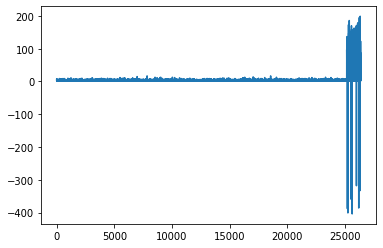

In [23]:
plt.plot(rewards)

Mean reward: -1.4733333333333334 Num episodes: 600


-1.4733333333333334

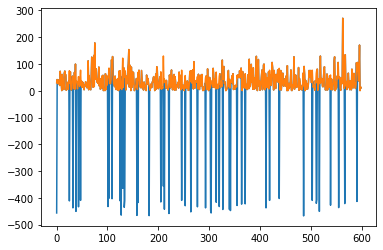

In [24]:
evaluate(model, env_test, 600)